# Network Analysis Of Cilmbers And Their Partners - 3002

## Purpose

Now we look at all the climber data and their partners, and try to conclude whether climbers who climb during the restricted periods climb in big groups or separately. 

We also examine whether one needs to be a good enough climber in a group to be an influential one.

We try and find the answers to the two research questions in this notebook:

### Research Question 2: Is there are a large set of climbers who climb in groups during the restriced time of the year?

### Research Question 3: Do a network analysis of the climber groups in general and compare them with the climbing groups which climb during restrictions. Find their attributes.

In [1]:
import pandas as pd
import numpy as np

import urllib.request
from urllib.request import urlopen

import matplotlib.pyplot as plt
import networkx as nx
from networkx.utils.decorators import not_implemented_for

from bs4 import BeautifulSoup
from datetime import datetime

import re
import os
import ast

### Importing The Dataset From the CSV File

We import the ascents data from the UKC website which we have already scraped and saved locally

In [2]:
climber_data=pd.read_csv('ascents_cleaned.csv')

#### Cleaning The Dataset

In [3]:
climber_data=climber_data.drop("Unnamed: 0", axis=1)
len(climber_data)

57794

The two functions below modify the date column of the dataframe to convert them to datetime objects, which makes it easier to examine the ascents according to the time they were logged.

In [4]:
def parse_date(date_str):
    
    try:
        return datetime.strptime(date_str, '%d %b, %Y')  #Valid date format
    except:
        try:
            return datetime.strptime(date_str, '%d %b')   #Another valid format (missing year, assume current year)
        except: 
            return False

In [5]:
def convert_datetime(date_str):
    
    dt = parse_date(date_str)
    
    if dt:
        day, month, year = dt.day, dt.month, dt.year
        
        #Deal with valid missing year format
        if year == 1900:
            year = datetime.now().year
        
        return pd.Series({'day': day, 'month': month, 'year': year})
    else:
        return pd.Series()

We add the day, month, and year columns to the dataframe to manipulate the dataframe according to the date.

In [6]:
climber_data_with_dates=pd.concat([climber_data, climber_data['date'].apply(convert_datetime)], axis=1)

In [7]:
climber_data_with_dates.head(10)

,name,date,style,comment,climber_id,grade,location,local_to,avg_grade,max_grade,upset,day,month,year
0,Hurricane,"15 Oct, 2018",Lead O/S,Another brilliant FH E2. Lead both pitches and...,57132,E2,Fair Head,Bas Cuvier,E1,E4,0,15.0,10.0,2018.0
1,Hurricane,"19 Jul, 2018",Lead O/S,Led both pitch,233566,E2,Fair Head,Vivian Quarry,E1,E2,0,19.0,7.0,2018.0
2,Hurricane,"7 Jul, 2018",AltLd O/S,with Robert Duran,133563,E2,Fair Head,St. Govan's Head,E2,E4,0,7.0,7.0,2018.0
3,Hurricane,"25 Jun, 2018",AltLd O/S,Great splitter climbing.with Mike Hutton,12933,E2,Fair Head,Gorges du Tarn,E2,E4,0,25.0,6.0,2018.0
4,Hurricane,"4 Jun, 2018",AltLd O/S,Amazing! Led p2with Aggie,158515,E2,Fair Head,Froggatt Edge,HVS,E4,0,4.0,6.0,2018.0
5,Hurricane,"3 Jun, 2018",AltLd O/S,Pitch 1with bren,151893,E2,Fair Head,Dalkey quarry,E2,E7,0,3.0,6.0,2018.0
6,Hurricane,"10 Jul, 2017",AltLd O/S,P2. Started up direct finish but hard so went ...,35159,E2,Fair Head,Boulder Ruckle,E2,E5,0,10.0,7.0,2017.0
7,Hurricane,"10 Jul, 2017",AltLd O/S,P1 what a cracker!with Ed Babs,41303,E2,Fair Head,Winspit,E1,E5,0,10.0,7.0,2017.0
8,Hurricane,"2 Jun, 2017",AltLd O/S,NaN,213309,E2,Fair Head,Dalkey quarry,E2,E5,0,2.0,6.0,2017.0
9,Hurricane,"2 Jun, 2017",AltLd O/S,Lead P2. Great teamwork! ðŸ˜with Wendy Watthews,200143,E2,Fair Head,Brean Down,HVS,E5,0,2.0,6.0,2017.0


Any row with missing dates is no use to us for the research questions 2 and 3, so we delete those rows.

In [8]:
climber_data_with_dates.dropna(subset=['day', 'month', 'year'], how='any')

,name,date,style,comment,climber_id,grade,location,local_to,avg_grade,max_grade,upset,day,month,year
0,Hurricane,"15 Oct, 2018",Lead O/S,Another brilliant FH E2. Lead both pitches and...,57132,E2,Fair Head,Bas Cuvier,E1,E4,0,15.0,10.0,2018.0
1,Hurricane,"19 Jul, 2018",Lead O/S,Led both pitch,233566,E2,Fair Head,Vivian Quarry,E1,E2,0,19.0,7.0,2018.0
2,Hurricane,"7 Jul, 2018",AltLd O/S,with Robert Duran,133563,E2,Fair Head,St. Govan's Head,E2,E4,0,7.0,7.0,2018.0
3,Hurricane,"25 Jun, 2018",AltLd O/S,Great splitter climbing.with Mike Hutton,12933,E2,Fair Head,Gorges du Tarn,E2,E4,0,25.0,6.0,2018.0
4,Hurricane,"4 Jun, 2018",AltLd O/S,Amazing! Led p2with Aggie,158515,E2,Fair Head,Froggatt Edge,HVS,E4,0,4.0,6.0,2018.0
5,Hurricane,"3 Jun, 2018",AltLd O/S,Pitch 1with bren,151893,E2,Fair Head,Dalkey quarry,E2,E7,0,3.0,6.0,2018.0
6,Hurricane,"10 Jul, 2017",AltLd O/S,P2. Started up direct finish but hard so went ...,35159,E2,Fair Head,Boulder Ruckle,E2,E5,0,10.0,7.0,2017.0
7,Hurricane,"10 Jul, 2017",AltLd O/S,P1 what a cracker!with Ed Babs,41303,E2,Fair Head,Winspit,E1,E5,0,10.0,7.0,2017.0
8,Hurricane,"2 Jun, 2017",AltLd O/S,NaN,213309,E2,Fair Head,Dalkey quarry,E2,E5,0,2.0,6.0,2017.0
9,Hurricane,"2 Jun, 2017",AltLd O/S,Lead P2. Great teamwork! ðŸ˜with Wendy Watthews,200143,E2,Fair Head,Brean Down,HVS,E5,0,2.0,6.0,2017.0


In [9]:
climber_data_with_dates[["date"]]=pd.to_datetime(climber_data_with_dates[["day", "month", "year"]], format='%d%m%Y')

In [10]:
climber_data_with_dates.head(10)

,name,date,style,comment,climber_id,grade,location,local_to,avg_grade,max_grade,upset,day,month,year
0,Hurricane,2018-10-15,Lead O/S,Another brilliant FH E2. Lead both pitches and...,57132,E2,Fair Head,Bas Cuvier,E1,E4,0,15.0,10.0,2018.0
1,Hurricane,2018-07-19,Lead O/S,Led both pitch,233566,E2,Fair Head,Vivian Quarry,E1,E2,0,19.0,7.0,2018.0
2,Hurricane,2018-07-07,AltLd O/S,with Robert Duran,133563,E2,Fair Head,St. Govan's Head,E2,E4,0,7.0,7.0,2018.0
3,Hurricane,2018-06-25,AltLd O/S,Great splitter climbing.with Mike Hutton,12933,E2,Fair Head,Gorges du Tarn,E2,E4,0,25.0,6.0,2018.0
4,Hurricane,2018-06-04,AltLd O/S,Amazing! Led p2with Aggie,158515,E2,Fair Head,Froggatt Edge,HVS,E4,0,4.0,6.0,2018.0
5,Hurricane,2018-06-03,AltLd O/S,Pitch 1with bren,151893,E2,Fair Head,Dalkey quarry,E2,E7,0,3.0,6.0,2018.0
6,Hurricane,2017-07-10,AltLd O/S,P2. Started up direct finish but hard so went ...,35159,E2,Fair Head,Boulder Ruckle,E2,E5,0,10.0,7.0,2017.0
7,Hurricane,2017-07-10,AltLd O/S,P1 what a cracker!with Ed Babs,41303,E2,Fair Head,Winspit,E1,E5,0,10.0,7.0,2017.0
8,Hurricane,2017-06-02,AltLd O/S,NaN,213309,E2,Fair Head,Dalkey quarry,E2,E5,0,2.0,6.0,2017.0
9,Hurricane,2017-06-02,AltLd O/S,Lead P2. Great teamwork! ðŸ˜with Wendy Watthews,200143,E2,Fair Head,Brean Down,HVS,E5,0,2.0,6.0,2017.0


### We create a new dataframe for each of the locations(Gogarth South Stack, Stennis, and St. Govan) which have some sort of climbing restrictions during some time of the year. These dataframes contain the ascents longged by climbers during the restricted periods. We then keep only ine ascent per climber, and delete the rest.

In [11]:
climber_data_with_dates_gogarth_south_stack_restricted=climber_data_with_dates[(climber_data_with_dates.location=="Gogarth South Stack") & (climber_data_with_dates.month>=2.0) & (climber_data_with_dates.month<=7)]

In [12]:
len(climber_data_with_dates_gogarth_south_stack_restricted)

1277

In [13]:
unique_climbers_gogarth_south_stack_restricted=climber_data_with_dates_gogarth_south_stack_restricted.drop_duplicates(subset="climber_id",keep="first",inplace=False)
unique_climbers_gogarth_south_stack_restricted



,name,date,style,comment,climber_id,grade,location,local_to,avg_grade,max_grade,upset,day,month,year
7301,Mousetrap,1989-07-26,AltLd O/S,led 1st and 3rd pitcheswith steve ward,34852,E2,Gogarth South Stack,Castle Inn Quarry,E1,E5,0,26.0,7.0,1989.0
7403,Wendigo,1975-04-12,AltLd O/S,"Wendigo, Rat Race and Big Groove in a day. Pet...",95981,E2,Gogarth South Stack,Stanage Popular,HVS,E4,0,12.0,4.0,1975.0
7487,Lighthouse Arete,2018-07-27,AltLd O/S,"with stephenmckenzie, NinaR",197943,VS,Gogarth South Stack,Stanage Popular,VS,E3,0,27.0,7.0,2018.0
7488,Lighthouse Arete,2018-07-27,AltLd O/S,"with NinaR, josefft",97264,VS,Gogarth South Stack,Stanage Popular,MVS,E1,0,27.0,7.0,2018.0
7489,Lighthouse Arete,2018-07-25,AltLd O/S,"In 3 pitches, led middle pitch to the second l...",124529,VS,Gogarth South Stack,Australia,HVS,E3,0,25.0,7.0,2018.0
7490,Lighthouse Arete,2018-07-21,AltLd O/S,Led P1 and 2. It would be fine at HS and noone...,131981,VS,Gogarth South Stack,Stanage Popular,S,HVS,0,21.0,7.0,2018.0
7491,Lighthouse Arete,2018-07-19,Lead rpt,With Tamsin,181130,VS,Gogarth South Stack,Sierra de Toix,HS,VS,0,19.0,7.0,2018.0
7492,Lighthouse Arete,2018-07-05,Lead O/S,NaN,231939,VS,Gogarth South Stack,Shepherd’s Crag,VS,E3,0,5.0,7.0,2018.0
7493,Lighthouse Arete,2018-07-05,AltLd O/S,with elliotphillips43,242482,VS,Gogarth South Stack,Shorn Cliff,HVS,E2,0,5.0,7.0,2018.0
7495,Lighthouse Arete,2018-06-27,AltLd O/S,I did P1\nFantastic climbing. The real atmosph...,153844,VS,Gogarth South Stack,Craig Bwlch y Moch (Tremadog),HS,E1,0,27.0,6.0,2018.0


By looking at the charts below, we thought that most of the climbers who disobeyed the restrictions were from Stanage Popular.

In [14]:
climber_data_with_dates_govan_restriced=climber_data_with_dates[(climber_data_with_dates.location=="St. Govan's Head") & (climber_data_with_dates.month>=3.0) & (climber_data_with_dates.month<=7)]

In [15]:
len(climber_data_with_dates_govan_restriced)

2376

In [16]:
unique_climbers_govan_restriced=climber_data_with_dates_govan_restriced.drop_duplicates(subset="climber_id",keep="first",inplace=False)
unique_climbers_govan_restriced


,name,date,style,comment,climber_id,grade,location,local_to,avg_grade,max_grade,upset,day,month,year
18203,Lemming Way,2018-04-22,Lead G/U,NaN,122058,S,St. Govan's Head,Hen Cloud,HS,HVS,1,22.0,4.0,2018.0
18206,Lemming Way,2017-05-20,Lead O/S,with Sophie Nunn,11616,S,St. Govan's Head,Blacknor North,MVS,E3,0,20.0,5.0,2017.0
18207,Lemming Way,2017-04-17,Lead dnf,Made it most of the way on a day when head was...,154016,S,St. Govan's Head,Horseshoe Quarry,MVS,VS,1,17.0,4.0,2017.0
18208,Lemming Way,2017-04-17,Lead β,"Top roped the first section, lead the topwith ...",160354,S,St. Govan's Head,Monsummano,MVS,VS,0,17.0,4.0,2017.0
18209,Lemming Way,2017-04-16,Lead O/S,with will_lake,175882,S,St. Govan's Head,Avon Gorge (Sea Walls Area),MVS,E1,0,16.0,4.0,2017.0
18210,Lemming Way,2017-03-12,Lead O/S,with NatalieB96,194220,S,St. Govan's Head,Burbage North,S,E4,0,12.0,3.0,2017.0
18213,Lemming Way,2016-04-30,Lead O/S,Warm up route - the top looks like it's going ...,142940,S,St. Govan's Head,Sennen,MS,E1,0,30.0,4.0,2016.0
18217,Lemming Way,2015-06-07,Lead O/S,with Clare F,14680,S,St. Govan's Head,Stanage Popular,S,E2,0,7.0,6.0,2015.0
18218,Lemming Way,2015-06-07,Lead O/S,with Chris Densham,43755,S,St. Govan's Head,San Vito lo Capo Salinella,HVD,VS,0,7.0,6.0,2015.0
18219,Lemming Way,2015-05-23,Lead O/S,with Melissa McDonald,120203,S,St. Govan's Head,Stanage North,MVS,E1,0,23.0,5.0,2015.0


In [17]:
climber_data_with_dates_stennis_restriced=climber_data_with_dates[(climber_data_with_dates.location=="Stennis Head") & (climber_data_with_dates.month>=3.0) & (climber_data_with_dates.month<=7)]

In [18]:
len(climber_data_with_dates_stennis_restriced)

1588

In [19]:
unique_climbers_stennis_restriced=climber_data_with_dates_stennis_restriced.drop_duplicates(subset="climber_id",keep="first",inplace=False)
unique_climbers_stennis_restriced

,name,date,style,comment,climber_id,grade,location,local_to,avg_grade,max_grade,upset,day,month,year
22718,Myola,2018-06-30,Lead rpt,with Montecore,78120,HS,Stennis Head,Crookrise,S,E2,0,30.0,6.0,2018.0
22719,Myola,2018-06-16,Lead O/S,Never a VS as the Climbers Club guide gives it,199569,HS,Stennis Head,Wyndcliff Quarry,MVS,E2,0,16.0,6.0,2018.0
22720,Myola,2018-05-05,Lead rpt,with Tiernan,197656,HS,Stennis Head,Stennis Head,HS,HVS,0,5.0,5.0,2018.0
22721,Myola,2018-04-14,Lead O/S,with TeenageMutantClimbingTurtle,143637,HS,Stennis Head,Stanage Popular,VS,E4,0,14.0,4.0,2018.0
22731,Myola,2017-07-22,Lead O/S,with Julian Duxfield,214911,HS,Stennis Head,Stanage Popular,HS,E2,0,22.0,7.0,2017.0
22732,Myola,2017-06-23,Lead O/S,with Rocknast,210675,HS,Stennis Head,Stanage Popular,VS,E1,0,23.0,6.0,2017.0
22733,Myola,2017-05-27,Lead O/S,with ThomasDunn,104103,HS,Stennis Head,Roaches Lower Tier,MVS,HVS,0,27.0,5.0,2017.0
22734,Myola,2017-05-15,Lead O/S,with Polly Checkley,184546,HS,Stennis Head,Ban-y-gor,HVS,E3,0,15.0,5.0,2017.0
22735,Myola,2017-04-29,Lead O/S,with mariedlj,200436,HS,Stennis Head,Battleship Back Cliff,MVS,E2,0,29.0,4.0,2017.0
22736,Myola,2017-04-16,Lead O/S,"From low tide mark, didn't add much to the cli...",97993,HS,Stennis Head,The Cuttings Boulderfield,MVS,E4,0,16.0,4.0,2017.0


#### By looking at the charts below, we thought that most of the climbers who disobeyed the restrictions were from Stanage Popular. The charts below plots the percentage of the climbers in each area and where they were local to:

Text(0, 0.5, 'Number of Climbers')

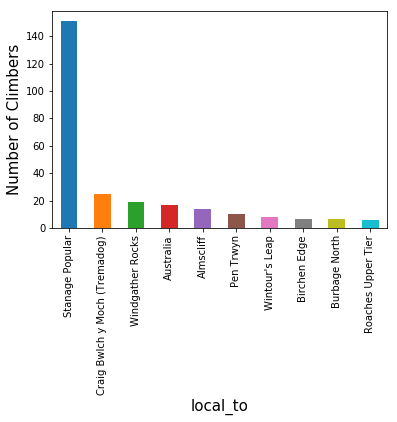

In [49]:
s=unique_climbers_gogarth_south_stack_restricted['local_to'].value_counts()
pl=s.head(10).plot(kind='bar')
pl.set_xlabel('local_to', fontsize=15)
pl.set_ylabel('Number of Climbers', fontsize=15)

Text(0, 0.5, 'Number of Climbers')

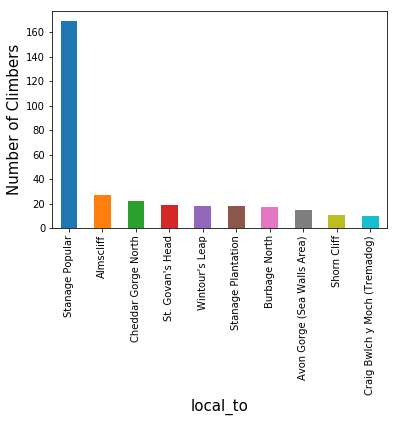

In [50]:
s=unique_climbers_govan_restriced['local_to'].value_counts()
pl=s.head(10).plot(kind='bar')
pl.set_xlabel('local_to', fontsize=15)
pl.set_ylabel('Number of Climbers', fontsize=15)

Text(0, 0.5, 'Number of Climbers')

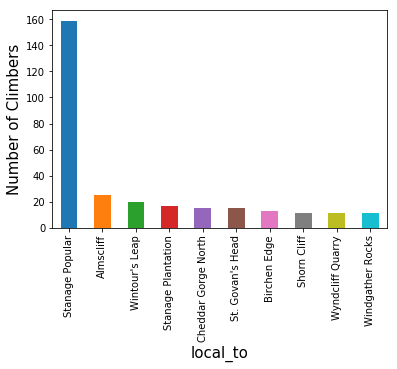

In [51]:
s=unique_climbers_stennis_restriced['local_to'].value_counts()
pl=s.head(10).plot(kind='bar')
pl.set_xlabel('local_to', fontsize=15)
pl.set_ylabel('Number of Climbers', fontsize=15)

#### But that wasn't the case. Climbers in general, came from Stanage Popular the most. This was made clear by the chart below. which plots the percentage of all the climbers against where they were local to:

Text(0, 0.5, 'Number of Climbers')

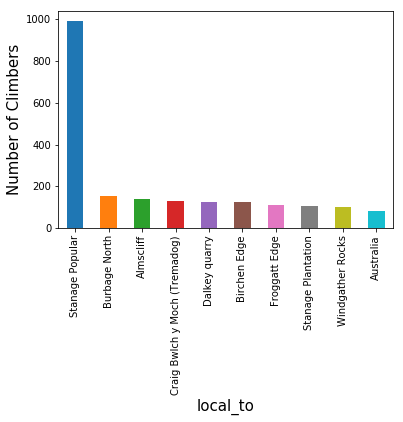

In [52]:
x=climber_data_with_dates.drop_duplicates(subset="climber_id",keep="first",inplace=False)
s=x['local_to'].value_counts()
pl=s.head(10).plot(kind='bar')
pl.set_xlabel('local_to', fontsize=15)
pl.set_ylabel('Number of Climbers', fontsize=15)

Now we create three lists, each list containing the unique climber ids from each of the three dataframes of the restricted areas: 

In [24]:
gogarth_climber_id_restricted=climber_data_with_dates_gogarth_south_stack_restricted['climber_id'].unique().tolist()

In [25]:
govan_climber_id_restricted=climber_data_with_dates_govan_restriced['climber_id'].unique().tolist()

In [26]:
stennis_climber_id_restricted=climber_data_with_dates_stennis_restriced['climber_id'].unique().tolist()

We create a new dataframe called climber_data_with_dates_new, which contains all the ascents minus the ascents made during the restricted times:

In [27]:
union=pd.concat([climber_data_with_dates_gogarth_south_stack_restricted, climber_data_with_dates_govan_restriced, climber_data_with_dates_stennis_restriced])
union=union.drop_duplicates()

climber_data_with_dates_new=pd.concat([climber_data_with_dates, union]).drop_duplicates(keep=False)

The cell below keeps only one ascent per climber id in a new dataframe called unique_total_climbers:

In [28]:
unique_total_climbers=climber_data_with_dates_new.drop_duplicates(subset="climber_id",keep="first",inplace=False)
len(unique_total_climbers)




5231

We now make a list of all the unique climber ids in the dataset that we have:

In [29]:
unique_total_climbers_id_list=unique_total_climbers['climber_id'].tolist()
len(unique_total_climbers_id_list)

5231

## Scraping Individual Climber HTML And Extracting Their Partners

In [30]:
link='raw/{}.html'

The two functions below help in the extraction of the partners of each climber. 

The function get_partners returns a list of partner ids if given a climber id, if the climber has partners in the dataframe. Otherwise, it returns False.

The function common checks if the list of partner ids are there in the actual dataset or not, and only sends back the list of partners who are present in their respective datasets.

In [31]:
def common(l1,l2): 
    l3=[value for value in l1 if value in l2] 
    return l3

In [32]:
def get_partners(climb):
    id_link=link.format(climb)
    try:
        f=open(id_link,"r")
        source =f.read()
        #source=urllib.request.urlopen(id_link).read()
        soup=BeautifulSoup(source,'html.parser')

        tables=soup.find('div',{'id':'partner'})
        if tables is not None:
            tables=soup.find('div',{'id':'partner'}).parent.find_all('a')
            l=pd.Series(re.findall(r'showgraph.php\?id=[0-9]+',str(tables)))
            if len(l)>0:    
                ids=pd.Series(l.map(lambda x:re.sub(r'.*=',r'',x)))
                return ids.tolist()
            else:
                return False
        else:
            return False
    except:
        return False

## Creating Edge List Dataframes

We create 4 edge lists of climbers and their partners below, the four of them being:
1. Climbers and their partners who have climbed during the non-restricted times of the year.
2. Climbers and their partners who have climbed Gogarth during the restricted time of the year.
3. Climbers and their partners who have climbed St. Govan during the restricted time of the year.
4. Climbers and their partners who have climbed Stennis during the restricted time of the year.

Each of these edge list dataframes contains climber and partner pair, and the colour of their edges.


In [33]:
edge_list=[]
column_1=[]
column_2=[]
column_3=[]
val='red'

In [34]:
for climber in unique_total_climbers_id_list:
    li = get_partners(climber)
    if li !=False:
        li=[int(x) for x in li]
        l=common(li,unique_total_climbers_id_list)
        if(len(l)>0):
            i=l[0]
            test_2=[j for j in l[1:]]
            test_1=[i for j in l[1:]]
            column_1=(column_1+test_1)
            column_2=(column_2+test_2)
            edge=[[i,j] for j in l[1:]]
            edge_list=(edge_list+edge)

In [35]:
for i in column_1:
    column_3.append(val)
    
total_df_edge_list= pd.DataFrame(
    {'node_1': column_1,
     'node_2': column_2,
     'color': column_3
    })

In [36]:
total_df_edge_list.head(10)

,node_1,node_2,color
0,57132,60038,red
1,57132,127308,red
2,12933,41486,red
3,12933,49323,red
4,12933,367,red
5,158515,214945,red
6,158515,194101,red
7,158515,151784,red
8,158515,189077,red
9,158515,129044,red


In [37]:
len(total_df_edge_list)

9768

In [38]:
edge_list_1=[]
column_1=[]
column_2=[]
column_3=[]
val='blue'

In [39]:
for climber in gogarth_climber_id_restricted:
    li = get_partners(climber)
    if li !=False:
        li=[int(x) for x in li]
        l=common(li,gogarth_climber_id_restricted)
        if(len(l)>0):
            i=l[0]
            test_2=[j for j in l[1:]]
            test_1=[i for j in l[1:]]
            column_1=(column_1+test_1)
            column_2=(column_2+test_2)
            edge=[[i,j] for j in l[1:]]
            edge_list_1=(edge_list_1+edge)

In [40]:
for i in column_1:
    column_3.append(val)
    
gogarth_df_edge_list= pd.DataFrame(
    {'node_1': column_1,
     'node_2': column_2,
     'color': column_3
    })

In [41]:
edge_list_2=[]
column_1=[]
column_2=[]
column_3=[]
val='blue'

In [42]:
for climber in govan_climber_id_restricted:
    li = get_partners(climber)
    if li !=False:
        li=[int(x) for x in li]
        l=common(li,govan_climber_id_restricted)
        if(len(l)>0):
            i=l[0]
            test_2=[j for j in l[1:]]
            test_1=[i for j in l[1:]]
            column_1=(column_1+test_1)
            column_2=(column_2+test_2)
            edge=[[i,j] for j in l[1:]]
            edge_list_2=(edge_list_2+edge)

In [43]:
for i in column_1:
    column_3.append(val)
    
govan_df_edge_list= pd.DataFrame(
    {'node_1': column_1,
     'node_2': column_2,
     'color': column_3
    })

In [44]:
edge_list_3=[]
column_1=[]
column_2=[]
column_3=[]
column_4=[]
val='blue'

In [45]:
for climber in stennis_climber_id_restricted:
    li = get_partners(climber)
    if li !=False:
        li=[int(x) for x in li]
        l=common(li,stennis_climber_id_restricted)
        if(len(l)>0):
            i=l[0]
            test_2=[j for j in l[1:]]
            test_1=[i for j in l[1:]]
            column_1=(column_1+test_1)
            column_2=(column_2+test_2)
            edge=[[i,j] for j in l[1:]]
            edge_list_3=(edge_list_3+edge)

In [46]:
for i in column_1:
    column_3.append(val)
    
stennis_df_edge_list= pd.DataFrame(
    {'node_1': column_1,
     'node_2': column_2,
     'color': column_3
    })

We create one more edge list dataframe to stack all the edges from all the edge lists, in order to visualise that network.

In [47]:
new_df=pd.concat([total_df_edge_list, gogarth_df_edge_list, govan_df_edge_list, stennis_df_edge_list], axis=0, join='outer', join_axes=None, ignore_index=True,
          keys=None, levels=None, names=None, verify_integrity=False, copy=True)
new_df.sample(10)

,node_1,node_2,color
9014,114368,48434,red
9767,159281,22256,red
4375,89533,123750,red
12457,13199,10385,blue
7652,184196,206620,red
11297,99379,127291,blue
3710,27941,118023,red
2942,105453,93333,red
5286,96073,95076,red
10391,65335,17897,blue


# Visualisation Of The Network

We use networkX to visualise these connections between the climbers and their partners. There are 4 graphs below:
1. Network for the entire dataset.
2. Network for the Gogarth climbers during the restricted time.
3. Network for the St. Govan climbers during the restricted time.
4. Network for the Stennis climbers during the restricted time.

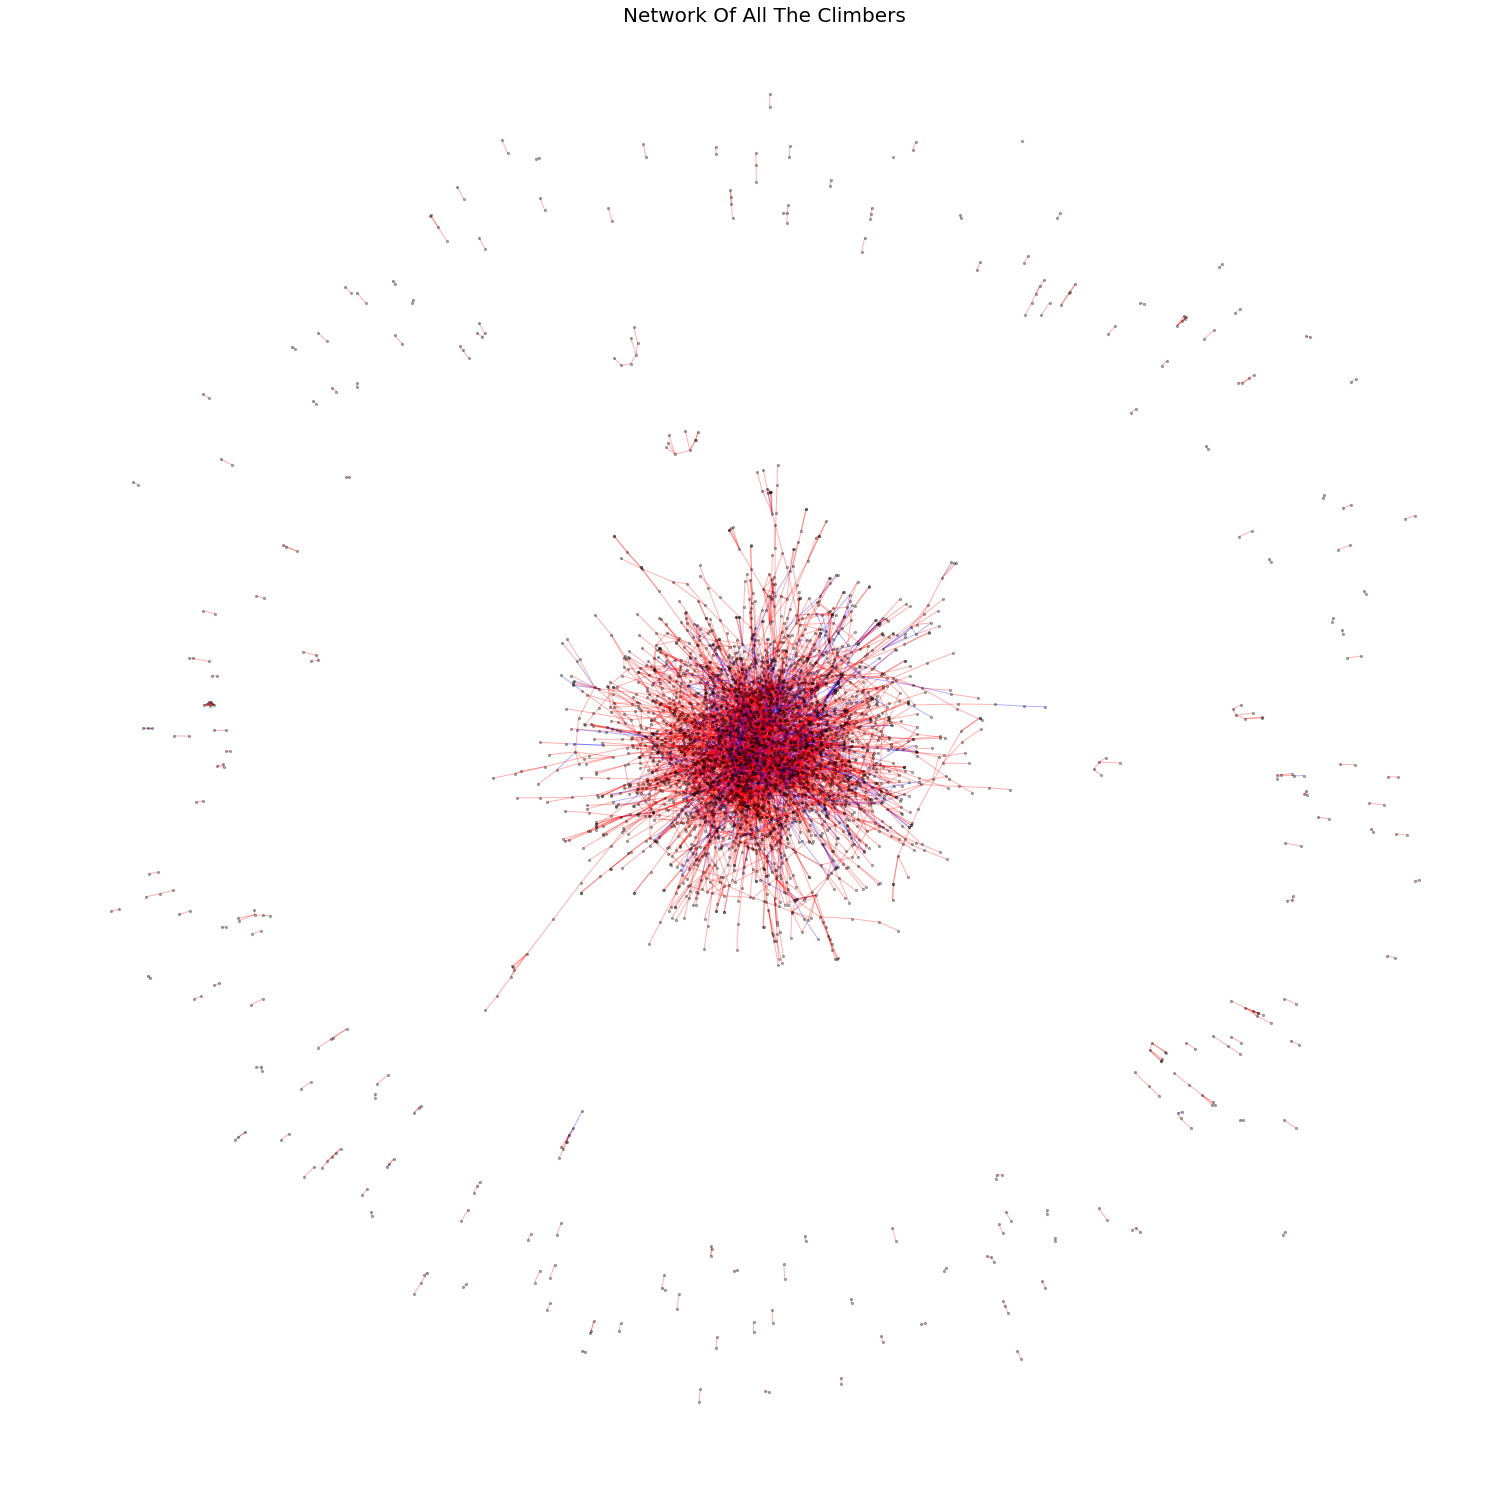

In [56]:
g_1=nx.Graph()
for i, elrow in new_df.iterrows():
    g_1.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

edge_colors = [e[2]['attr_dict']['color'] for e in g_1.edges(data=True)]
plt.figure(figsize=(20,20))
nx.draw(g_1, edge_color=edge_colors, node_size=5, node_color='black', alpha=0.3)
plt.title('Network Of All The Climbers', size=20)
plt.show()

Each node represents a climber, and each edge represents that those two climbers have climbed together. The above graph shows two types of edges. The red edge means that the two climbers have climbed together a route during the non-restricted time of the year. The blue edge means that the two climbers have climbed together one route among Gogarth, St. Govan's, or Stennis, during the restricted time of the year. The denser areas in the graph represent big groups and the more influential climber groups in the climbers list. The fact that the blue colored edges are visible enough among the dense red edges indicates that there is a good number of groups which don't obey the restrictions.

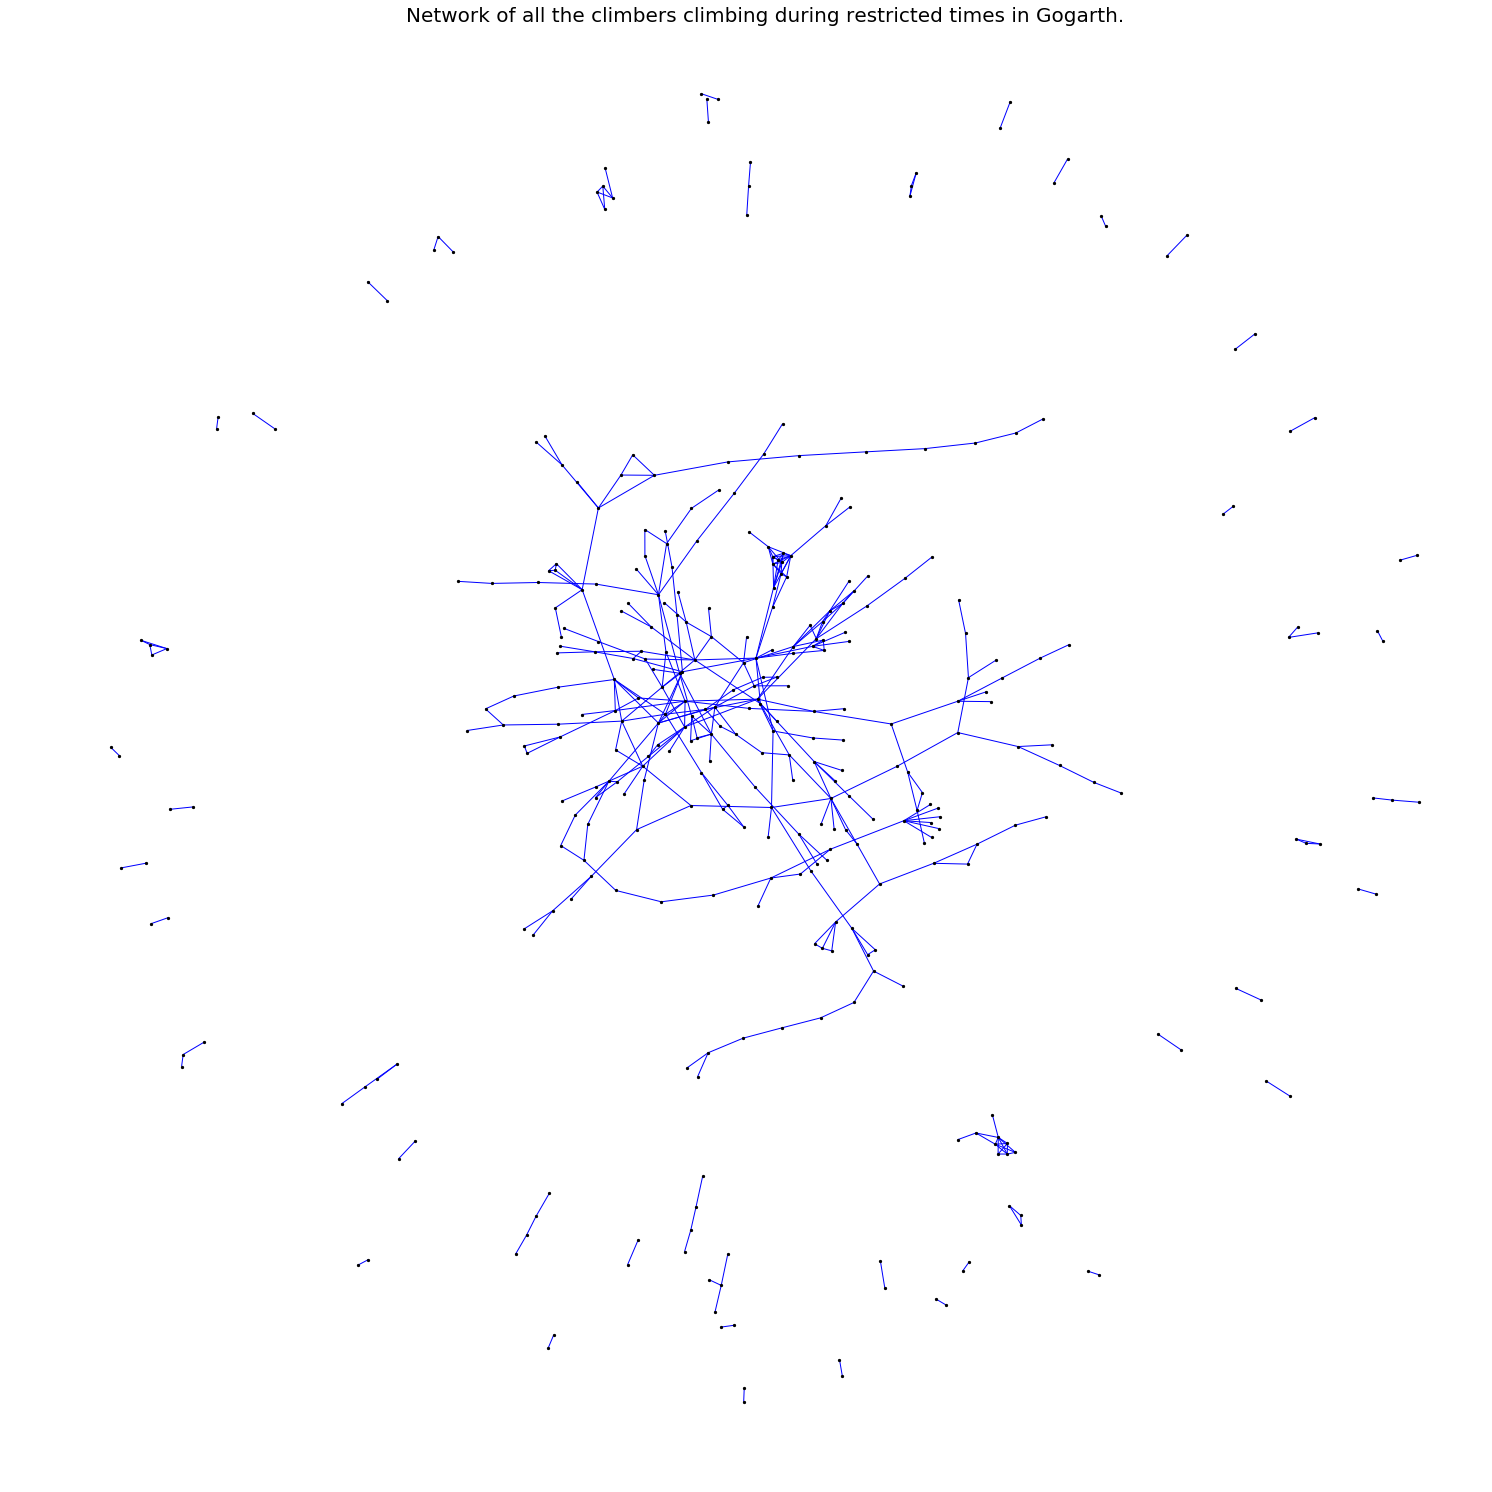

In [57]:
g = nx.Graph()
for i, elrow in gogarth_df_edge_list.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

edge_colors = [e[2]['attr_dict']['color'] for e in g.edges(data=True)]
plt.figure(figsize=(20,20))
nx.draw(g, edge_color=edge_colors, node_size=5, node_color='black')
plt.title('Network of all the climbers climbing during restricted times in Gogarth.', size=20)
plt.show()

The above graph represents the climbers and their edges from the Gogarth.

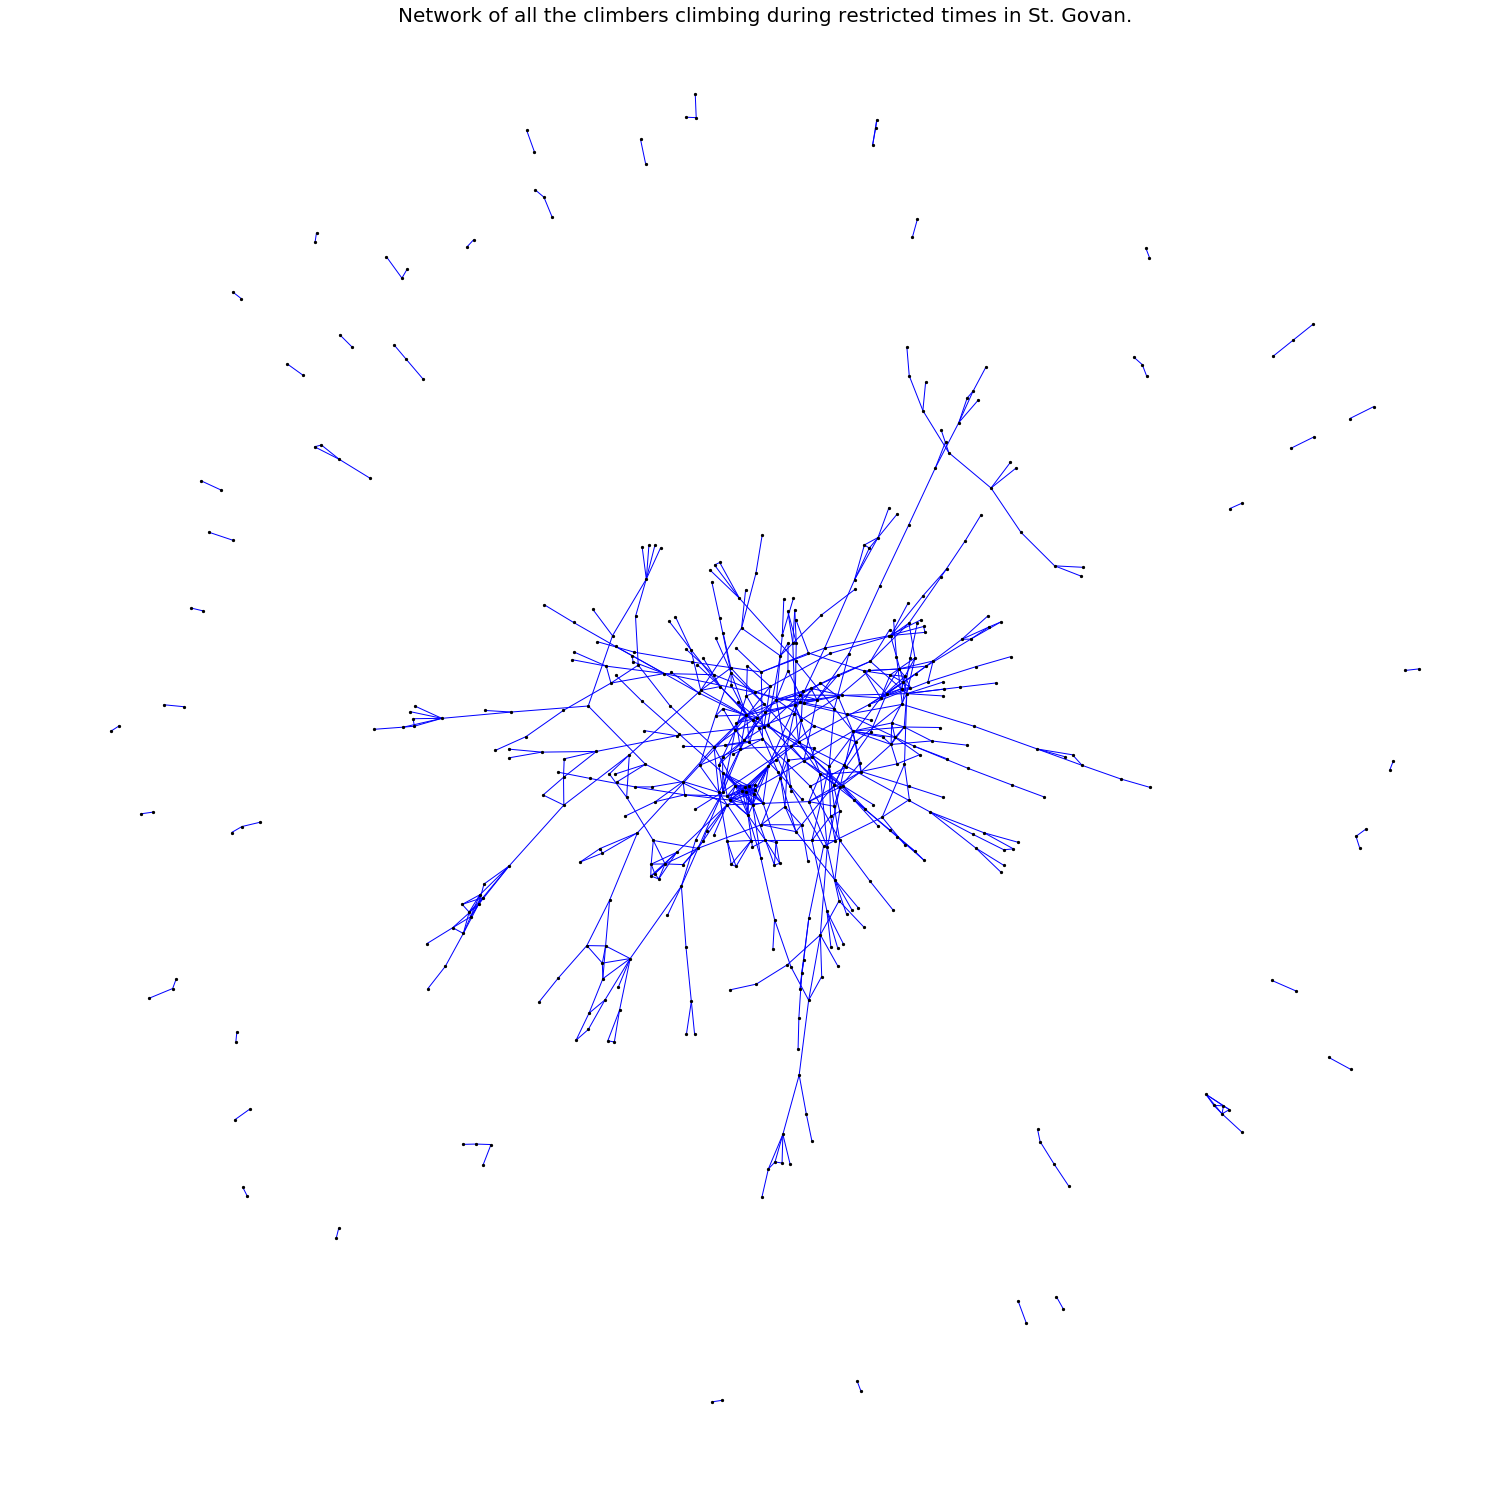

In [58]:
g = nx.Graph()
for i, elrow in govan_df_edge_list.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

edge_colors = [e[2]['attr_dict']['color'] for e in g.edges(data=True)]
plt.figure(figsize=(20,20))
nx.draw(g, edge_color=edge_colors, node_size=5, node_color='black')
plt.title('Network of all the climbers climbing during restricted times in St. Govan.', size=20)
plt.show()

The above graph represents the climbers and their edges from the St Govan's.

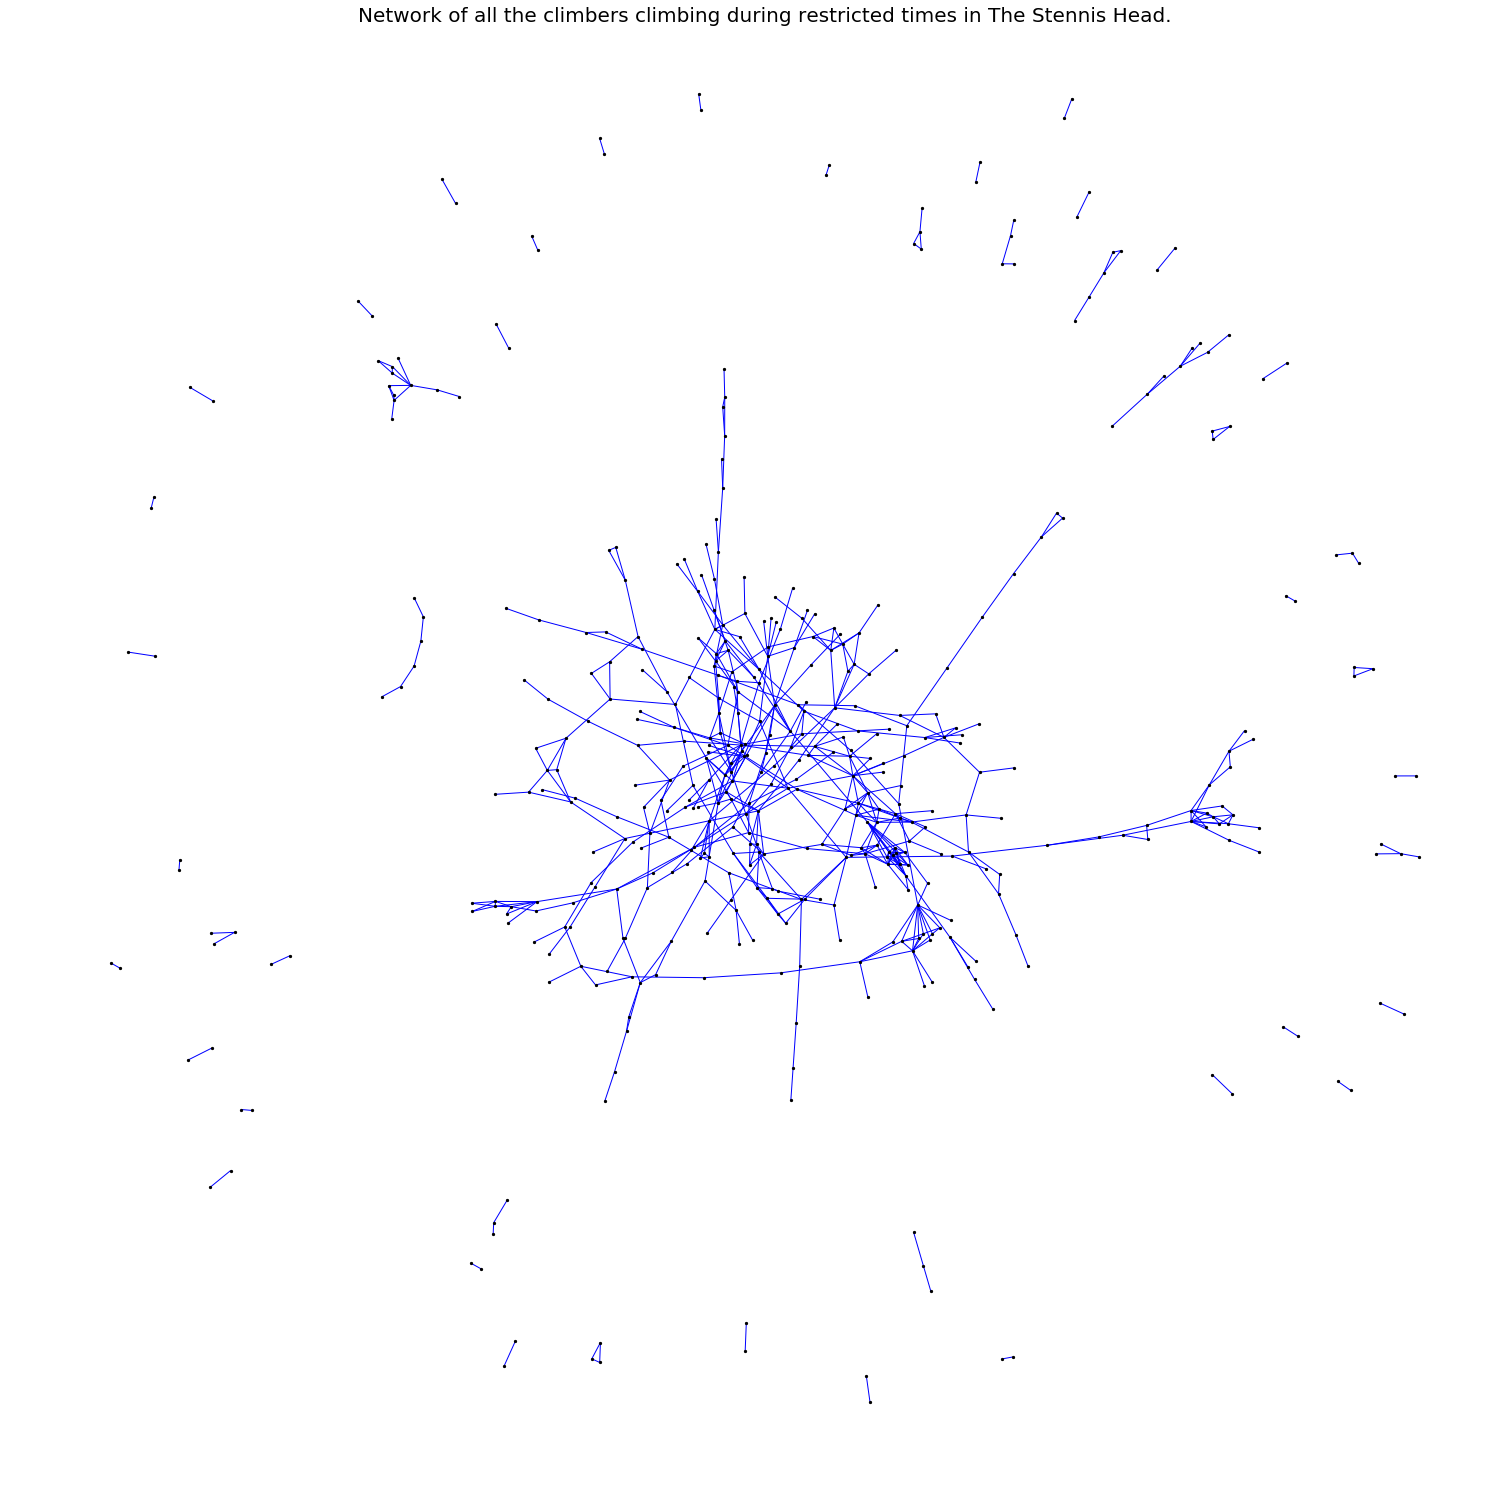

In [59]:
g = nx.Graph()
for i, elrow in stennis_df_edge_list.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

edge_colors = [e[2]['attr_dict']['color'] for e in g.edges(data=True)]
plt.figure(figsize=(20,20))
nx.draw(g, edge_color=edge_colors, node_size=5, node_color='black')
plt.title('Network of all the climbers climbing during restricted times in The Stennis Head.', size=20)
plt.show()

The above graph represents the climbers and their edges from the Stennis Head.

#### Now, we merge the three routes into a single edge list, and form a network.

In [60]:
new_df_2=pd.concat([gogarth_df_edge_list, govan_df_edge_list, stennis_df_edge_list], axis=0, join='outer', join_axes=None, ignore_index=True,
          keys=None, levels=None, names=None, verify_integrity=False, copy=True)

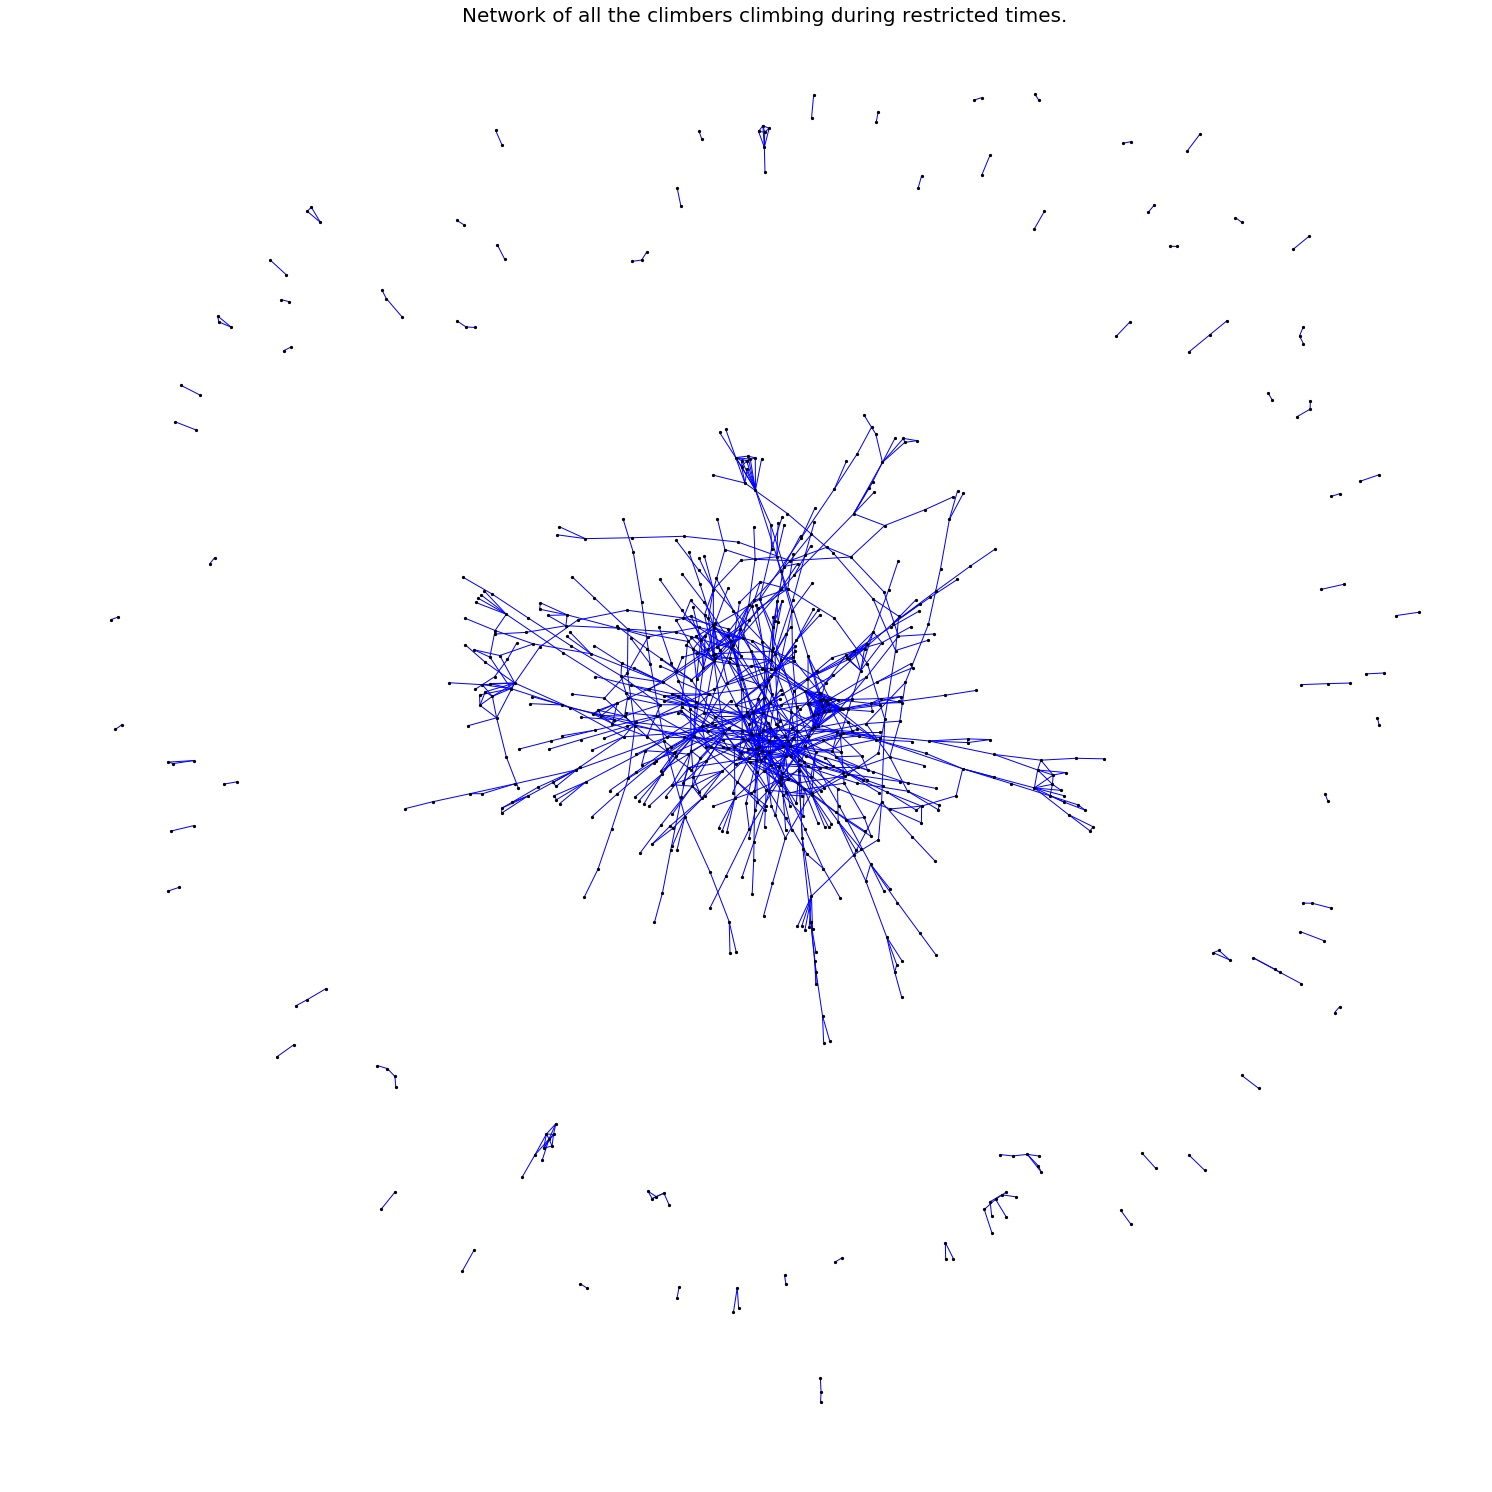

In [61]:
g_d=nx.Graph()
for i, elrow in new_df_2.iterrows():
    g_d.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())

edge_colors = [e[2]['attr_dict']['color'] for e in g_d.edges(data=True)]
plt.figure(figsize=(20,20))
nx.draw(g_d, edge_color=edge_colors, node_size=5, node_color='black')
plt.title('Network of all the climbers climbing during restricted times.', size=20)
plt.show()

In [62]:
outdeg=g_d.degree() #Taking node-degree pair. 
num_groups=[node for (node,value) in outdeg if value > 1] #Taking the climbers with more than one partners.
num_single=[value for (node,value) in outdeg if value <= 1] #Taking the climbers with one partner.

percentage_group=(len(num_groups)/(len(num_groups)+len(num_single)))*100 #Percentage of climbers with more than one partners.
percentage_group

63.86740331491713

#### The above graph shows that there is a comparatively lesser percentage of climbers who climb in pairs, and a lot more climbers climb in groups of more than 2.

#### To demonstrate this, we did the above calculation of the node degrees. Almost 64 percent of the climbers during the restricted periods climb in groups larger than size 2, which answers the Research Question 2. 

#### To answer the third Research Question, we decided to look at the degree centrality of each climber and examine what makes a climber influential in a group.

In [63]:
def degree_centrality(G):
    if len(G)<=1:
        return {n: 1 for n in G}

    s=1.0/(len(G)-1.0)
    centrality={n: d*s for n, d in G.degree()}
    return centrality

In [64]:
dc=degree_centrality(g_d)

In [65]:
dc

{34852: 0.0022123893805309734,
 14873: 0.0022123893805309734,
 76013: 0.0022123893805309734,
 197943: 0.0022123893805309734,
 97264: 0.0011061946902654867,
 181130: 0.0011061946902654867,
 94864: 0.0011061946902654867,
 242482: 0.0011061946902654867,
 231939: 0.0011061946902654867,
 153844: 0.0011061946902654867,
 136323: 0.0022123893805309734,
 197486: 0.0011061946902654867,
 209553: 0.0011061946902654867,
 198196: 0.0022123893805309734,
 197775: 0.0022123893805309734,
 197940: 0.00331858407079646,
 132829: 0.00331858407079646,
 73673: 0.0011061946902654867,
 189485: 0.0022123893805309734,
 188110: 0.00331858407079646,
 151852: 0.00663716814159292,
 24102: 0.004424778761061947,
 187830: 0.0022123893805309734,
 147309: 0.0055309734513274336,
 95592: 0.00331858407079646,
 52875: 0.00331858407079646,
 116219: 0.0011061946902654867,
 222640: 0.0055309734513274336,
 163952: 0.007743362831858407,
 145032: 0.0011061946902654867,
 160377: 0.0011061946902654867,
 203187: 0.00331858407079646,
 

In [66]:
sorted_x=sorted(dc.items(), key=lambda kv: kv[1])

In [67]:
d=dict(sorted_x)

We now take the 100 climbers with the highest degree centrality in a dataframe.

In [68]:
top_100_gs=list()
temp=list()
for i in d.keys():
    temp.append(i)
top_100_gs=temp[-100:]

In [69]:
top_100_df=pd.DataFrame()

We extract one ascent each for these 100 climbers in a dataframe:

In [70]:
for i in top_100_gs:
    top_100_df=pd.concat([top_100_df, climber_data_with_dates[(climber_data_with_dates.climber_id==i)]], axis=0, join='outer', join_axes=None, ignore_index=True,
          keys=None, levels=None, names=None, verify_integrity=False, copy=True)

In [71]:
top_100_df=top_100_df.drop_duplicates(subset="climber_id",keep="first",inplace=False)

In [72]:
top_100_df.head(10)

,name,date,style,comment,climber_id,grade,location,local_to,avg_grade,max_grade,upset,day,month,year
0,Cemetery Gates,2016-06-02,AltLd O/S,"led first pitch, then did first ever hanging b...",131144,E1,Dinas Cromlech,Cromlech boulders,HVS,E3,0,2.0,6.0,2016.0
11,Midnight Cruiser,2016-06-25,Lead O/S,Not very pumpy and not very hard but quite sus...,151852,E1,Fair Head,Pen Trwyn,HVS,E4,0,25.0,6.0,2016.0
143,North West Passage,2018-05-12,Lead rpt,NaN,45912,E1,Gogarth South Stack,Sierra de Toix,VS,E4,0,12.0,5.0,2018.0
155,Lighthouse Arete,2014-06-07,AltLd O/S,Lead P1 and 2 togetherwith Chi Cheng,96073,VS,Gogarth South Stack,Almscliff,VS,E4,0,7.0,6.0,2014.0
219,Sabre Cut,2013-04-20,AltLd O/S,with herman0055,93333,VS,Dinas Cromlech,Almscliff,E2,E5,0,20.0,4.0,2013.0
305,Memory Lane,2014-10-02,Lead O/S,Good climbing to the ledge after the crux. Did...,79368,E3,Dinas Cromlech,St. Govan's Head,E2,E6,0,2.0,10.0,2014.0
390,Levitation,2006-07-23,Lead O/S,with Smitz's Wife,20469,HS,Dalkey quarry,Windgather Rocks,MS,E2,0,23.0,7.0,2006.0
425,Burn Up,2010-06-17,AltLd O/S,"Led P1, awesomewith crossdressingrodney",11336,E1,Fair Head,Stanage Popular,HS,E1,0,17.0,6.0,2010.0
514,Noah's Warning,2011-04-09,Lead O/S,with EarlyBird,59899,VS,Dinas Cromlech,Stanage Popular,HVS,E2,0,9.0,4.0,2011.0
653,Hell's Kitchen,2015-06-05,AltLd dog,"P2. Good climbing, but a bit of a pull on the ...",190791,HVS,Fair Head,Stanage Popular,VS,E2,1,5.0,6.0,2015.0


Text(0, 0.5, 'Number of Climbers')

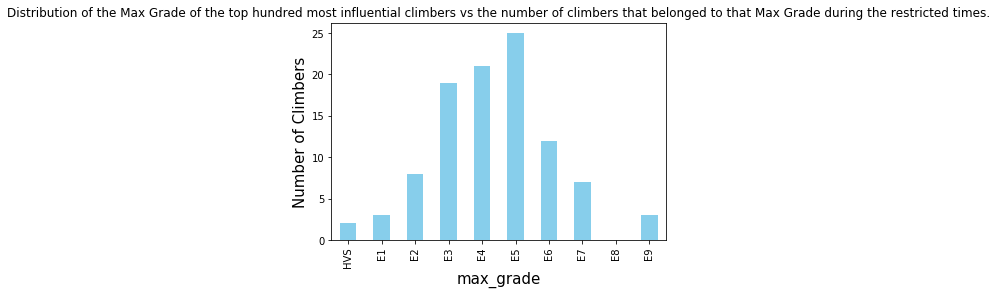

In [76]:
s=top_100_df['max_grade'].value_counts().reindex(['HVS','E1','E2','E3','E4','E5','E6','E7','E8','E9'])
plt=s.plot(kind='bar',color='skyblue', title="Distribution of the Max Grade of the top hundred most influential climbers vs the number of climbers that belonged to that Max Grade during the restricted times.")
plt.set_xlabel('max_grade', fontsize=15)
plt.set_ylabel('Number of Climbers', fontsize=15)

#### The above graph plots the max_grade of climbers in the top 100 list vs the number of climbers which have that max grade. 

Text(0, 0.5, 'Number of Climbers')

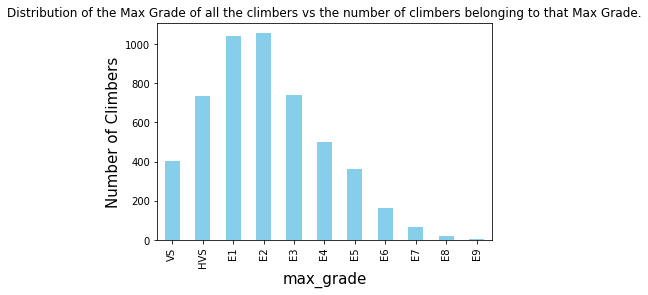

In [77]:
tot_df=pd.DataFrame()
for i in unique_total_climbers_id_list:
    tot_df=pd.concat([tot_df, climber_data_with_dates[(climber_data_with_dates.climber_id==i)]], axis=0, join='outer', join_axes=None, ignore_index=True,
          keys=None, levels=None, names=None, verify_integrity=False, copy=True)
    
tot_df=tot_df.drop_duplicates(subset="climber_id",keep="first",inplace=False)

s=tot_df['max_grade'].value_counts().reindex(['VS','HVS','E1','E2','E3','E4','E5','E6','E7','E8','E9'])
plt=s.plot(kind='bar',color='skyblue',title="Distribution of the Max Grade of all the climbers vs the number of climbers belonging to that Max Grade.")
plt.set_xlabel('max_grade', fontsize=15)
plt.set_ylabel('Number of Climbers', fontsize=15)

#### The above graph plots the max_grade of climbers in the entire dataset vs the number of climbers which have that max grade. 

#### Our initial understanding of the dataset from the graph of the all the climbers vs their max grades was that one doesn't need to be a very good climber (have a high max grade) to be an influential climber (have a lot of partners). The majority of the climbers had max_grade E1 or E2.

#### But after narrowing the sample set to the top 100 climbers (they have the most number of partners), it was visible visible from the chart that the majority of the climbers had a max_grade of E5. Very few of the top 100 climbers had a low max_grade.

## Conclusion
1. More than half the climbers who climb during restricted times have more than one partners, and climb in groups of size more than 2. (RQ 2)
2. A climber needs to be good (have a high max_grade) in order to be influential (have a high number of partners compared to the others) in a network of climbers. (RQ 3)